# File and libraries

In [18]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_0_pre_proc.csv'

excel_mapping_filepath=r'data/df_merch_values_encoded.xlsx'

file_tag = "Google Merch Shop"


# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
# test_data=True
test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 10% sample
    sample=0.1
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


else:
    data=pd.read_csv(filepath)

 

# encoded dataframe duplication
data_enc = data.copy()

data_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371499 entries, 0 to 371498
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   event_name                       371499 non-null  object 
 1   device_category                  371499 non-null  object 
 2   device_mobile_brand_name         371499 non-null  object 
 3   device_mobile_model_name         371499 non-null  object 
 4   device_operating_system          371499 non-null  object 
 5   device_operating_system_version  258781 non-null  object 
 6   device_language                  198631 non-null  object 
 7   device_web_info_browser          371499 non-null  object 
 8   device_web_info_browser_version  371499 non-null  object 
 9   geo_country                      371499 non-null  object 
 10  geo_region                       367101 non-null  object 
 11  geo_city                         351064 non-null  object 
 12  tr

# bulk Symbolic mapping through Excel

## Encoding logic

- event_name: content interaction events -> page_view -> ecommerce events

- device_category: desktop, tablet middle, mobile

- device_mobile_brand_name: PC Brands and Browsers together. Smartphones together 

- device_mobile_model_name: Grouped similarly with the brand name

- device_language: english languages grouped and with higher ordinal values

- device_operating_system_version: grouped similarly to device and browser versions. clustered PC and smartphone values

- device_operating_system:  clustered PC and smartphone values

- device_web_info_browser: Chrome in the middle.

- device_web_info_browser_version: Chrome in the middle.

- geo_country: no particular order. two values

- traffic_source_medium: google traffic in the middle together with direct

- traffic_source_source: google traffic in the middle together with direct

- page_path_level_1 : shop categories+products closer, then main ecommerce journey and misc pages

- page_path_level_2 : shop categories+products closer, then main ecommerce journey and misc pages

- page_path_level_3 : shop categories+products closer, then main ecommerce journey and misc pages

- year : ordinal time series from older to newer

- quarter : ordinal time series from older to newer

- month : ordinal time series from older to newer

- day_of_year : ordinal time series from older to newer 

- week_number : ordinal time series from older to newer

In [5]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in data_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)

        # Encode the corresponding column in data_enc using the mapping
        data_enc[sheet] = encode_column_with_mapping(data_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")

event_name column encoded
device_category column encoded
device_mobile_brand_name column encoded
device_mobile_model_name column encoded
device_language column encoded
device_operating_system_version column encoded
device_operating_system column encoded
device_web_info_browser column encoded
device_web_info_browser_version column encoded
geo_country column encoded
traffic_source_medium column encoded
traffic_source_source column encoded
domain column encoded
page_path_level_1 column encoded
page_path_level_2 column encoded
page_path_level_3 column encoded
year column encoded
quarter column encoded
month column encoded
day_of_year column encoded
week_number column encoded


# Geo columns
Using the distance from a central point, like Google's headquarters in California, as a proxy for geographical encoding can be a clever approach. For GA4 datasets related to Google services, proximity to headquarters (Mountain View, California) might correlate with certain behaviors or delivery times.

## geo_region
Using the distance from a central point, like Google's headquarters in California, as a proxy for geographical encoding can be a clever approach. For GA4 datasets related to Google services, proximity to headquarters (Mountain View, California) might correlate with certain behaviors or delivery times.

In [6]:
geo_region_list = data['geo_region'].tolist()
distinct_geo_regions = list(set(geo_region_list))

print(distinct_geo_regions)

['Newfoundland and Labrador', 'Louisiana', 'Maryland', 'Iowa', 'Kansas', 'Connecticut', 'Michigan', 'New Jersey', 'Nebraska', 'Tennessee', 'Wyoming', 'Vermont', 'Oklahoma', 'Kentucky', 'Alberta', 'Oregon', 'North Dakota', 'Massachusetts', 'New York', 'Colorado', 'Wisconsin', 'British Columbia', 'Mississippi', 'California', 'Alabama', 'North Carolina', 'Quebec', 'Florida', 'Minnesota', 'Prince Edward Island', 'Illinois', 'Arizona', 'Maine', 'Virginia', nan, 'Nevada', 'Georgia', 'Washington', 'Indiana', 'Saskatchewan', 'Utah', 'Pennsylvania', 'New Mexico', 'Nova Scotia', 'Missouri', 'West Virginia', 'Rhode Island', 'Ohio', 'Texas', 'New Hampshire', 'South Dakota', 'South Carolina', 'Montana', 'Idaho', 'Hawaii', 'Arkansas', 'Delaware', 'Ontario', 'Alaska', 'Manitoba', 'District of Columbia', 'New Brunswick']


## geo region distances

In [7]:
region_distances_to_google_hq = {
    "Prince Edward Island": 5790,
    "Tennessee": 3491,
    "Ohio": 3840,
    "New Jersey": 4711,
    "Illinois": 3461,
    "Nebraska": 2260,
    "Quebec": 5041,
    "Washington": 1370,
    "Nevada": 360,
    "North Carolina": 4371,
    "Saskatchewan": 2321,
    "Hawaii": 3870,  # Flight, no driving possible
    "South Carolina": 4251,
    "Alabama": 3651,
    "West Virginia": 4161,
    "Colorado": 1880,
    "Pennsylvania": 4382,
    "Wisconsin": 3462,
    "Virginia": 4321,
    "Missouri": 2960,
    "Connecticut": 4792,
    "Florida": 4531,
    "Oklahoma": 2381,
    "South Dakota": 2430,
    "New Hampshire": 4962,
    "Texas": 2730,
    "Montana": 1751,
    "Arizona": 1020,
    "Newfoundland and Labrador": 6491,
    "California": 0,  # Google's HQ is in California
    "Nova Scotia": 5971,
    "Massachusetts": 4953,
    "North Dakota": 2292,
    "Manitoba": 2791,
    "Delaware": 4582,
    "Alberta": 2131,
    "Alaska": 4372,
    "Louisiana": 3552,
    "Mississippi": 3782,
    "Iowa": 2961,
    "Indiana": 3621,
    "New Mexico": 1670,
    "Ontario": 4312,
    "District of Columbia": 4341,
    "Maine": 5153,
    "Kansas": 2472,
    "Utah": 1140,
    "Rhode Island": 4854,
    "New Brunswick": 5631,
    "Georgia": 3952,
    "Maryland": 4462,
    "Vermont": 5055,
    "Minnesota": 3040,
    "British Columbia": 1580,
    "New York": 4663,
    "Idaho": 1081,
    "Arkansas": 2940,
    "Wyoming": 1671,
    "Kentucky": 3762,
    "Oregon": 1030,
    "Michigan": 3913
}


In [8]:
data_enc['geo_region'] = encode_column_with_mapping(data_enc, 'geo_region', region_distances_to_google_hq)


# geo_city

In [9]:
geo_city_list = data['geo_city'].tolist()
distinct_geo_cities = list(set(geo_city_list))

print(distinct_geo_cities)

['Burlington', 'Montgomery', 'Waterloo', 'Dallas', 'Gatineau', 'El Paso', 'Burlingame', 'Mississauga', 'Pacifica', 'Lubbock', 'Livonia', 'Surrey', 'Sacramento', 'Round Rock', 'Dublin', 'Elgin', 'Tempe', 'Boardman', 'Costa Mesa', 'Sherwood Park', 'Louisville', 'Kansas City', 'Ottawa', 'Boise', 'Goose Creek', 'Lawrenceville', 'Lexington', 'Chatham-Kent', 'Walnut Creek', 'Roslyn Heights', 'Thunder Bay', 'Huntsville', 'Moncton', 'Boston', 'Malden', 'St. Petersburg', 'Levis', 'Frisco', 'Redmond', 'Fredericton', 'Woodstock', 'San Antonio', 'Wilmington', 'Rancho Cucamonga', 'Saint Paul', 'Coffeyville', 'Vancouver', 'Rochester', 'Los Angeles', 'Long Beach', 'Pittsburgh', 'Salmon Arm', 'Cincinnati', 'Auburn', 'Berkeley', nan, 'Washington', 'Jersey City', 'Jackson', 'San Ramon', 'Newmarket', 'Milton', 'Baltimore', 'Corpus Christi', 'Bakersfield', 'North Bergen', 'Chula Vista', 'Maple Ridge', 'Concord', 'Abbotsford', 'Asheville', 'Buffalo', 'San Bruno', 'Mesquite', 'Eau Claire', 'Lancaster', 'Lan

## geo cities distances

In [10]:
city_distances_to_google_hq = {
    "Saint-Jean-sur-Richelieu": 4820,  # Canada
    "Bakersfield": 430,                # CA
    "Aurora": 1670,                    # CO
    "Chula Vista": 780,                # CA
    "Round Rock": 2700,                # TX
    "Cincinnati": 3680,                # OH
    "Jersey City": 4750,               # NJ
    "Frisco": 2700,                    # TX
    "Walnut Creek": 60,                # CA
    "Beaverton": 1000,                 # OR
    "Dublin": 50,                      # CA
    "Anchorage": 4600,                 # AK
    "Franklin": 3700,                  # TN
    "Salt Lake City": 1150,            # UT
    "Albany": 4680,                    # NY
    "Daly City": 55,                   # CA
    "Saint John": 5410,                # Canada (NB)
    "Granby": 4820,                    # Canada (QC)
    "Mississauga": 4340,               # Canada (ON)
    "Murfreesboro": 3550,              # TN
    "Gainesville": 4180,               # FL
    "Waukesha": 3450,                  # WI
    "Anaheim": 600,                    # CA
    "Baton Rouge": 3340,               # LA
    "Pleasanton": 60,                  # CA
    "Washington": 4560,                # DC
    "Berkeley": 75,                    # CA
    "Winnipeg": 3150,                  # Canada (MB)
    "Clermont": 4270,                  # FL
    "Quebec City": 4930,               # Canada (QC)
    "Greater Sudbury": 4280,           # Canada (ON)
    "Virginia Beach": 4630,            # VA
    "Eau Claire": 3150,                # WI
    "New Orleans": 3700,               # LA
    "Tempe": 1040,                     # AZ
    "Bridgeport": 4820,                # CT
    "St. Petersburg": 4480,            # FL
    "Saratoga": 24,                    # CA
    "Riverside": 630,                  # CA
    "Denver": 1670,                    # CO
    "Little Rock": 2860,               # AR
    "Louisville": 3630,                # KY
    "Vaudreuil-Dorion": 4820,          # Canada (QC)
    "San Diego": 740,                  # CA
    "Knoxville": 3600,                 # TN
    "Mobile": 3800,                    # AL
    "Champaign": 3450,                 # IL
    "Newmarket": 4350,                 # Canada (ON)
    "Campbell": 30,                    # CA
    "Everett": 1350,                   # WA
    "Reston": 4530,                    # VA
    "Chattanooga": 3700,               # TN
    "Ontario": 600,                    # CA
    "Des Moines": 2720,                # IA
    "Morgan Hill": 50,                 # CA
    "Philadelphia": 4700,              # PA
    "Rochester": 4550,                 # NY
    "Halifax": 5630,                   # Canada (NS)
    "Toledo": 3950,                    # OH
    "Chantilly": 4550,                 # VA
    "Albuquerque": 1650,               # NM
    "Clarksville": 3550,               # TN
    "Milpitas": 20,                    # CA
    "Redwood City": 30,                # CA
    "Houston": 2970,                   # TX
    "Coffeyville": 2840,               # KS
    "Wilmington": 4700,                # DE
    "Lawrenceville": 4150,             # GA
    "Spokane": 1300,                   # WA
    "Richmond": 4550,                  # VA
    "Saint Paul": 3150,                # MN
    "Birmingham": 3720,                # AL
    "Cambridge": 4990,                 # MA
    "Thunder Bay": 3830,               # Canada (ON)
    "Nashville": 3550,                 # TN
    "Pasadena": 600,                   # CA
    "Levis": 4930,                     # Canada (QC)
    "San Jose": 30,                    # CA
    "Santa Monica": 600,               # CA
    "Abbotsford": 1400,                # Canada (BC)
    "Fresno": 270,                     # CA
    "Gatineau": 4750,                  # Canada (QC)
    "Montreal": 4820,                  # Canada (QC)
    "Rockford": 3450,                  # IL
    "Roseville": 200,                  # CA
    "Roslyn Heights": 4750,            # NY
    "Milton": 4350,                    # Canada (ON)
    "Johns Creek": 4100,               # GA
    "St. Louis": 3080,                 # MO
    "Cherry Hill": 4700,               # NJ
    "Arlington Heights": 3450,         # IL
    "Portland": 1050,                  # OR
    "Malden": 4990,                    # MA
    "Hayward": 40,                     # CA
    "Buffalo": 4400,                   # NY
    "Ottawa": 4630,                    # Canada (ON)
    "Pflugerville": 2720,               # TX
    "Quincy": 4980,                   # MA
    "Corpus Christi": 2900,           # TX
    "Los Altos": 15,                  # CA
    "Menlo Park": 20,                 # CA
    "Wichita": 2430,                  # KS
    "Rancho Cucamonga": 630,          # CA
    "Langley Township": 1400,         # Canada (BC)
    "Charlotte": 4320,                # NC
    "Omaha": 2280,                    # NE
    "Reno": 350,                      # NV
    "Redmond": 1350,                  # WA
    "Alexandria": 4550,               # VA
    "San Leandro": 45,                # CA
    "Indianapolis": 3580,             # IN
    "Bellevue": 1350,                 # WA
    "South San Francisco": 50,        # CA
    "Manchester": 4990,               # NH
    "New York City": 4750,            # NY
    "North Bergen": 4750,             # NJ
    "Burnaby": 1400,                  # Canada (BC)
    "Memphis": 3440,                  # TN
    "Alameda": 50,                    # CA
    "Surrey": 1390,                   # Canada (BC)
    "Maple Ridge": 1410,              # Canada (BC)
    "Kalamazoo": 3650,                # MI
    "Terrebonne": 4820,               # Canada (QC)
    "Oakville": 4350,                 # Canada (ON)
    "Fredericton": 5410,              # Canada (NB)
    "Oshawa": 4330,                   # Canada (ON)
    "Stockton": 130,                  # CA
    "Colorado Springs": 1660,         # CO
    "Longueuil": 4820,                # Canada (QC)
    "Turner": 1060,                   # OR
    "Fontana": 630,                   # CA
    "Naperville": 3460,               # IL
    "Sioux Falls": 2300,              # SD
    "Kirkland": 1350,                 # WA
    "Cheyenne": 1700,                 # WY
    "Cleveland": 3930,                # OH
    "Arlington": 4700,                # VA
    "Hollywood": 620,                 # CA
    "Charlottesville": 4530,          # VA
    "Austin": 2720,                   # TX
    "Moncton": 5630,                  # Canada (NB)
    "Winston-Salem": 4320,            # NC
    "Oklahoma City": 2290,            # OK
    "Mesquite": 2710,                 # TX
    "Fargo": 2450,                    # ND
    "Port Coquitlam": 1410,           # Canada (BC)
    "Windsor": 4320,                  # Canada (ON)
    "Foster City": 30,                # CA
    "Minneapolis": 2650,              # MN
    "Mission Viejo": 630,             # CA
    "West Palm Beach": 4640,          # FL
    "Edison": 4750,                   # NJ
    "Woodstock": 4340,                # Canada (ON)
    "Billings": 1620,                 # MT
    "Auburn": 1090,                   # WA
    "The Woodlands": 3030,            # TX
    "Jackson": 3360,                  # MS
    "Coquitlam": 1410,                # Canada (BC)
    "Tulsa": 2400,                    # OK
    "San Mateo": 35,                  # CA
    "Fort Worth": 2720,               # TX
    "Saskatoon": 2610,                # Canada (SK)
    "Lincoln": 2240,                  # NE
    "Lexington": 3640,                # KY
    "Edmonton": 2350,                 # Canada (AB)
    "Evanston": 3470,                 # IL
    "Vancouver": 1400,                # Canada (BC)
    "Sammamish": 1350,                # WA
    "San Antonio": 2780,              # TX
    "Grand Rapids": 3900,             # MI
    "Ashburn": 4560,                  # VA
    "Paramus": 4750,                  # NJ
    "London": 4290,                   # Canada (ON)
    "Schaumburg": 3460,               # IL
    "Bethesda": 4540,                 # MD
    "Parsons": 2800,                  # KS
    "Fairfield": 80,                  # CA
    "Saguenay": 5100,                 # Canada (QC)
    "Hamilton": 4340,                 # Canada (ON)
    "Los Angeles": 600,               # CA
    "Yonkers": 4750,                  # NY
    "Farmington Hills": 3920,         # MI
    "North Creek": 4820,              # NY
    "Irving": 2700,                   # TX
    "Vaughan": 4350,                  # Canada (ON)
    "Nanaimo": 1450,                  # Canada (BC)
    "Lubbock": 2410,                  # TX
    "Boise": 970,                     # ID
    "Scottsdale": 1040,               # AZ
    "Gilbert": 1040,                  # AZ
    "Raleigh": 4320,                  # NC
    "Livonia": 3930,                  # MI
    "Tacoma": 1330,                   # WA
    "Barrie": 4360,                   # Canada (ON)
    "Guelph": 4330,                   # Canada (ON)
    "Jacksonville": 4580,             # FL
    "Elk Grove": 170,                 # CA
    "Montgomery": 3860,               # AL
    "Goose Creek": 4500,              # SC
    "Regina": 2440,                   # Canada (SK)
    "Eugene": 900,                    # OR
    "Mountain View": 0,               # CA (Base point)
    "Broken Arrow": 2460,             # OK
    "Boston": 4990,                   # MA
    "Salinas": 150,                   # CA
    "New York": 4750,                 # NY
    "Lethbridge": 2020,               # Canada (AB)
    "Calgary": 1960,                  # Canada (AB)
    "Brantford": 4330,                # Canada (ON)
    "Laval": 4820,                    # Canada (QC)
    "Richardson": 2700,               # TX
    "Redondo Beach": 610,             # CA
    "Greensboro": 4320,               # NC
    "Detroit": 3930,                  # MI
    "Fort Lauderdale": 4690,          # FL
    "Sherbrooke": 4980,               # Canada (QC)
    "North Vancouver": 1400,           # Canada (BC)    
    "Brentwood": 85,                  # CA
    "Springfield": 3300,              # MO
    "Seattle": 1330,                  # WA
    "Union City": 40,                 # CA
    "Ann Arbor": 3910,                # MI
    "Modesto": 145,                   # CA
    "Phoenix": 1040,                  # AZ
    "Metairie": 3600,                 # LA
    "Kelowna": 1700,                  # Canada (BC)
    "Kingston": 4320,                 # Canada (ON)
    "Plano": 2700,                    # TX
    "Miami": 4650,                    # FL
    "Chandler": 1040,                 # AZ
    "Gowanda": 4390,                  # NY
    "Newark": 4750,                   # NJ
    "St. John's": 7380,               # Canada (NL)
    "Baltimore": 4550,                # MD
    "Yorba Linda": 590,               # CA
    "Los Gatos": 30,                  # CA
    "Danville": 60,                   # CA
    "San Bruno": 55,                  # CA
    "Germantown": 4520,               # MD
    "Norfolk": 4580,                  # VA
    "Smyrna": 3490,                   # TN
    "Vista": 710,                     # CA
    "Tucson": 1220,                   # AZ
    "Milwaukee": 3420,                # WI
    "Orlando": 4550,                  # FL
    "Mesa": 1030,                     # AZ
    "Victoria": 1470,                 # Canada (BC)
    "Santa Clarita": 590,             # CA
    "Santa Ana": 600,                 # CA
    "McKinney": 2740,                 # TX
    "Kansas City": 2800,              # MO
    "Sugar Land": 3030,               # TX
    "Dallas": 2700,                   # TX
    "Columbia": 4350,                 # SC
    "El Paso": 1850,                  # TX
    "Boardman": 3850,                 # OH
    "Worcester": 4990,                # MA
    "Tampa": 4530,                    # FL
    "Santa Clara": 20,                # CA
    "Madison": 3460,                  # WI
    "Somerville": 4980,               # MA
    "Sherwood Park": 2350,            # Canada (AB)
    "Pickering": 4350,                # Canada (ON)
    "Oakland": 60,                    # CA
    "Richmond Hill": 4350,            # Canada (ON)
    "Cupertino": 15,                  # CA
    "Concord": 80,                    # CA
    "Blackhawk": 90,                  # CA
    "Cary": 4320,                     # NC
    "McLean": 4550,                   # VA
    "Toronto": 4340,                  # Canada (ON)
    "Charleston": 4500,               # SC
    "Lancaster": 590,                 # CA
    "Thornton": 1700,                 # CO
    "Sunnyvale": 10,                  # CA
    "Cypress": 590,                   # CA
    "Saint-Jerome": 4840,             # Canada (QC)
    "Providence": 5000,               # RI
    "Hoover": 3870,                   # AL
    "Marietta": 4180,                 # GA
    "Cumming": 4180,                  # GA
    "Glendale": 610,                  # CA
    "Hialeah": 4650,                  # FL
    "Dartmouth": 5400,                # Canada (NS)
    "Cedar Rapids": 2880,             # IA
    "Waterloo": 4330,                 # Canada (ON)
    "Secaucus": 4750,                 # NJ
    "College Station": 2850,          # TX
    "Honolulu": 3850,                 # HI (air travel)
    "Elgin": 3470,                    # IL
    "Columbus": 3940,                 # OH
    "San Ramon": 60,                  # CA
    "Chicago": 3470,                  # IL
    "Irvine": 600,                    # CA
    "San Carlos": 40,                 # CA
    "Brampton": 4350,                 # Canada (ON)
    "Markham": 4350,                  # Canada (ON)
    "Santa Cruz": 50,                 # CA
    "Las Vegas": 900,                 # NV
    "San Rafael": 75,                 # CA
    "Salmon Arm": 1720,               # Canada (BC)
    "Pacifica": 55,                   # CA
    "Fremont": 30,                    # CA
    "Huntsville": 3680,               # AL
    "Durham": 4320,                   # NC
    "Boca Raton": 4630,               # FL
    "Fort Wayne": 3700,               # IN
    "Palo Alto": 15,                  # CA
    "Long Beach": 600,                # CA
    "Burlingame": 50,                 # CA
    "Sandy Springs": 4180,            # GA
    "Kitchener": 4330,                # Canada (ON)
    "Livermore": 65,                  # CA
    "Stamford": 4760,                 # CT
    "St. Catharines": 4320,           # Canada (ON)
    "San Francisco": 55,              # CA
    "Ajax": 4350,                     # Canada (ON)
    "Sacramento": 160,                # CA
    "Costa Mesa": 590,                # CA
    "Clifton": 4750,                  # NJ
    "Boulder": 1700,                  # CO
    "Pittsburgh": 4080,               # PA
    "Laredo": 2680,                   # TX
    "Asheville": 4240,                # NC
    "Lakewood": 1620,                 # CO
    "Chatham-Kent": 4340,             # Canada (ON)
    "Chesapeake": 4590,               # VA
    "Hartford": 4980,                 # CT
    "Burlington": 4990,               # MA
    "Atlanta": 4180                   # GA  
}   


In [11]:
data_enc['geo_city'] = encode_column_with_mapping(data_enc, 'geo_city', city_distances_to_google_hq)


# Cyclic Variables

- time_of_day (performed manually)



- local_hour
- local_minute
- hour_minute_fraction
- day
- day_of_week_nr




# time_of_day

In [12]:
from math import pi, sin, cos

# Function to apply sin and cos on an already-mapped cyclic feature
def apply_sin_cos_for_mapped_column(data, column):
    data[column + '_sin'] = np.sin(data[column])  # apply sine
    data[column + '_cos'] = np.cos(data[column])  # apply cosine
    return data



day_of_week_encoding_mapping={
    'Night':0,   
    'Morning':pi/2,
    'Afternoon':pi,
    'Evening':-pi/2,   
}

data_enc['time_of_day'] = encode_column_with_mapping(data_enc, 'time_of_day', day_of_week_encoding_mapping)


# Apply sine and cosine encoding for the mapped 'time_of_day'
data_enc = apply_sin_cos_for_mapped_column(data_enc, 'time_of_day')

# Drop the original 'time_of_day' column if needed
data_enc.drop('time_of_day', axis=1, inplace=True)



# bulk cyclic variables

In [13]:
# Function to encode cyclic variables using sine and cosine
def cyclic_encode(value, x_max):
    # sine and cosine components to capture cyclic pattern
    value_sin = np.sin(2 * np.pi * value / x_max)
    value_cos = np.cos(2 * np.pi * value / x_max)
    return value_sin, value_cos


# Apply cyclic encoding for each variable, using both sin and cos

# Encoding for local_hour (0-23)
data_enc['local_hour_sin'], data_enc['local_hour_cos'] = zip(*data_enc['local_hour'].apply(lambda x: cyclic_encode(x, 23)))

# Encoding for local_minute (0-59)
data_enc['local_minute_sin'], data_enc['local_minute_cos'] = zip(*data_enc['local_minute'].apply(lambda x: cyclic_encode(x, 59)))

# Encoding for hour_minute_fraction (0-23.99)
data_enc['hour_minute_fraction_sin'], data_enc['hour_minute_fraction_cos'] = zip(*data_enc['hour_minute_fraction'].apply(lambda x: cyclic_encode(x, 23.99)))

# Encoding for day (1-31)
data_enc['day_sin'], data_enc['day_cos'] = zip(*data_enc['day'].apply(lambda x: cyclic_encode(x, 31)))

# Encoding for day_of_week (0-6)
data_enc['day_of_week_nr_sin'], data_enc['day_of_week_nr_cos'] = zip(*data_enc['day_of_week_nr'].apply(lambda x: cyclic_encode(x, 6)))

# encoding for week_of_month (0-6)
data_enc['week_of_month_nr_sin'], data_enc['week_of_month_nr_cos'] = zip(*data_enc['week_of_month'].apply(lambda x: cyclic_encode(x, 6)))


data_enc = data_enc.drop(['local_hour', 'local_minute', 'hour_minute_fraction','day', 'day_of_week_nr','week_of_month'], axis=1)


# correlation matrix

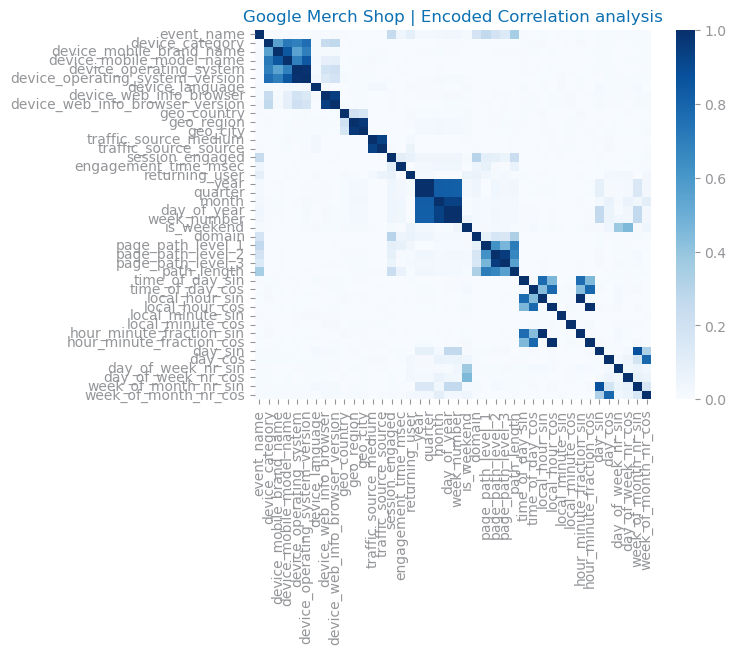

In [19]:
from seaborn import heatmap
from dslabs_functions import get_variable_types
from matplotlib.pyplot import figure, subplots, savefig, show, title


# variables_types: dict[str, list] = get_variable_types(data_enc)
# numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data_enc.corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=data_enc.columns,
    yticklabels=data_enc.columns,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

title(f'{file_tag} | Encoded Correlation analysis')


savefig(f"images/{file_tag}_enc_correlation_analysis.png")
show()

In [15]:
data_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371499 entries, 0 to 371498
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   event_name                       371499 non-null  int64  
 1   device_category                  371499 non-null  int64  
 2   device_mobile_brand_name         371499 non-null  int64  
 3   device_mobile_model_name         371497 non-null  float64
 4   device_operating_system          371499 non-null  int64  
 5   device_operating_system_version  258781 non-null  float64
 6   device_language                  198631 non-null  float64
 7   device_web_info_browser          371499 non-null  int64  
 8   device_web_info_browser_version  362151 non-null  float64
 9   geo_country                      371499 non-null  int64  
 10  geo_region                       367101 non-null  float64
 11  geo_city                         351064 non-null  float64
 12  tr

# save to csv

In [16]:
data_enc.to_csv('data/df_merch_2_encoded.csv',index=False)


# # Saving to CSV files
# train_df.to_csv('data/df_merch_encoded_train.csv', index=False)
# test_df.to_csv('data/df_merch_encoded_test.csv', index=False)


In [17]:
data_enc.shape

(371499, 42)